# LSTM Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing

%matplotlib inline

/home/harrison/anaconda3/envs/mas-thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
df_raw = pd.read_pickle('data/processed.pkl')
df_raw = df_raw.set_index('DATE')  # Index for timeseries is datetime

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708 entries, 1963-01-01 to 2021-12-01
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MSACSR                      708 non-null    float64
 1   MSPUS                       708 non-null    float64
 2   S&P Comp.                   708 non-null    float64
 3   Dividend                    708 non-null    float64
 4   Earnings                    708 non-null    float64
 5   CPI                         708 non-null    float64
 6   Long Interest Rate GS10     708 non-null    float64
 7   Real Price                  708 non-null    float64
 8   Real Dividend               708 non-null    float64
 9   Real Total Return Price     708 non-null    float64
 10  Real Earnings               708 non-null    float64
 11  Real TR Scaled Earnings     708 non-null    float64
 12  CAPE                        708 non-null    float64
 13  Total Return CAP

In [3]:
df_transformed = pd.read_pickle('data/differenced_df.pkl')
df_transformed = df_transformed.set_index('DATE')

df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 706 entries, 1963-02-01 to 2021-12-01
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MSACSR                      706 non-null    float64
 1   MSPUS                       706 non-null    float64
 2   S&P Comp.                   706 non-null    float64
 3   Dividend                    706 non-null    float64
 4   Earnings                    706 non-null    float64
 5   CPI                         706 non-null    float64
 6   Long Interest Rate GS10     705 non-null    float64
 7   Real Price                  706 non-null    float64
 8   Real Dividend               706 non-null    float64
 9   Real Total Return Price     706 non-null    float64
 10  Real Earnings               706 non-null    float64
 11  Real TR Scaled Earnings     706 non-null    float64
 12  CAPE                        706 non-null    float64
 13  Total Return CAP

### Data Preprocessing

In [4]:
## Drop imputed data
#df_no_imp = df_raw.iloc[::3, :].copy()  # Keep only quarterly data

#df = df_no_imp.copy()

# Re-compute logdiffs
#df['logdiff_MSPUS'] = np.log(df['MSPUS']).diff()

#df.head()

In [5]:
## For non differenced df

#df = df_raw.copy()

# Set target variable
#df['target'] = df_raw['logdiff_MSPUS']

# Remove extraneous columns
#df = df.drop(['MSPUS'], axis='columns')

# Remove first row since null for differenced columns
#df = df.drop(index=df.index[0], axis='index')

#print(df.shape)
#df.info()

In [6]:
# For differenced df

df = df_transformed.copy()

# Set target variable
df['target'] = df_transformed['MSPUS']

# Remove extraneous columns
df = df.drop(['MSPUS'], axis='columns')

# Remove first row since null for differenced columns
df = df.drop(index=df.index[0], axis='index')

print(df.shape)
df.info()

(705, 17)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 705 entries, 1963-03-01 to 2021-12-01
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MSACSR                      705 non-null    float64
 1   S&P Comp.                   705 non-null    float64
 2   Dividend                    705 non-null    float64
 3   Earnings                    705 non-null    float64
 4   CPI                         705 non-null    float64
 5   Long Interest Rate GS10     705 non-null    float64
 6   Real Price                  705 non-null    float64
 7   Real Dividend               705 non-null    float64
 8   Real Total Return Price     705 non-null    float64
 9   Real Earnings               705 non-null    float64
 10  Real TR Scaled Earnings     705 non-null    float64
 11  CAPE                        705 non-null    float64
 12  Total Return CAPE           705 non-null    float64
 13  Excess

In [7]:
# Split into input and target variables

X = df.drop('target', axis='columns')
y = df['target'].values
y = y.reshape(-1, 1)  # Put target variable into column vector shape

print(X.shape)
print(y.shape)
X.head()

(705, 16)
(705, 1)


,MSACSR,S&P Comp.,Dividend,Earnings,CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,CAPE,Total Return CAPE,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns
DATE,,,,,,,,,,,,,,,,
1963-03-01,-0.030772,-0.003800,0.004662,0.002699,0.003284,0.01,-0.007077,0.000000,-0.004359,0.000283,0.003039,-0.009288,-0.009599,0.011472,1.00,-0.000839
1963-04-01,-0.188591,0.045980,0.009259,0.010724,0.000000,0.04,0.045972,0.007786,0.048602,0.011541,0.014235,0.043617,0.043327,-0.104094,1.01,0.000000
1963-05-01,-0.038466,0.019871,0.004598,0.013245,0.000000,-0.04,0.019876,0.007245,0.022462,0.011410,0.014072,0.017708,0.017066,-0.034338,1.00,0.005860
1963-06-01,0.162519,-0.000428,0.009132,0.010471,0.003273,0.06,-0.003706,0.004322,-0.001090,0.008267,0.010686,-0.006359,-0.006210,-0.017622,1.00,-0.004182
1963-07-01,-0.265703,-0.014945,0.000000,0.010363,0.003263,0.03,-0.018204,-0.001439,-0.015553,0.007110,0.009754,-0.020323,-0.020983,0.047731,1.00,-0.002518


In [8]:
# Scale data

standard_scaler = sklearn.preprocessing.StandardScaler()  # Scales to mean of 0 and var of 1
minmax_scaler = sklearn.preprocessing.MinMaxScaler()  # Scale to between 0 and 1

X_scaled = standard_scaler.fit_transform(X)  
y_scaled = minmax_scaler.fit_transform(y)


print("X mean:", X_scaled.mean())
print("X var:", X_scaled.var())
print("y min:", y_scaled.min())
print("y max:", y_scaled.max())

X_reversed = standard_scaler.inverse_transform(X_scaled)
y_reversed = minmax_scaler.inverse_transform(y_scaled)

X mean: 7.259756231946058e-17
X var: 1.0
y min: 0.0
y max: 1.0


In [9]:
# NOTE: These values are for monthly data
#       Change these if interpolating!
IN_SEQ_LENGTH = 24
OUT_SEQ_LENGTH = 12

def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences):
            break
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
        
    return np.array(X), np.array(y)

X_seq, y_seq = split_sequences(X_scaled, y_scaled, IN_SEQ_LENGTH, OUT_SEQ_LENGTH)

# Make 
print(X_seq.shape, y_seq.shape)

assert y_seq[0].all() == y_scaled[IN_SEQ_LENGTH-1:IN_SEQ_LENGTH-1+OUT_SEQ_LENGTH].squeeze(1).all()

(671, 24, 16) (671, 12)


In [10]:
TEST_SIZE = 0.05

# Split data into train and test sets
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_seq, y_seq, test_size=TEST_SIZE)

# Convert datasets to nodes in computational graph
X_train_tensors = torch.Tensor(X_train)
y_train_tensors = torch.Tensor(y_train)
X_val_tensors = torch.Tensor(X_val)
y_val_tensors = torch.Tensor(y_val)

# Convert to sequential data for pytorch
X_train_tensors = torch.reshape(X_train_tensors, 
                                (X_train_tensors.shape[0], IN_SEQ_LENGTH, X_train_tensors.shape[2])
                               )
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0], IN_SEQ_LENGTH, X_val_tensors.shape[2]))


print(X_train_tensors.shape)
print(X_val_tensors.shape)

torch.Size([637, 24, 16])
torch.Size([34, 24, 16])


In [11]:
# Sanity Check data
X_check, y_check = split_sequences(X, y.reshape(-1, 1), IN_SEQ_LENGTH, OUT_SEQ_LENGTH)
print(X_check[-1][0:4])

start_ix = IN_SEQ_LENGTH + OUT_SEQ_LENGTH

#print(X.iloc[-start_ix + 1: -start_ix + 5])

[[-7.52234212e-02  5.50169036e-02  7.17640397e-03  4.94790724e-03
   4.24191403e-03 -3.00000000e-02  5.07994184e-02  3.03732949e-03
   5.24473138e-02  7.81555335e-04  2.42827110e-03  4.00606054e-02
   4.05503766e-02 -4.74397251e-02  1.01000000e+00  6.10811380e-04]
 [-9.84400728e-02  1.76732119e-02  7.30730325e-03  4.99795901e-03
   5.60181354e-03 -1.10000000e-01  1.20498524e-02  1.59489667e-03
   1.36791727e-02 -6.51253686e-04  9.78956358e-04  1.35318018e-03
   1.55110935e-03  5.51320707e-02  1.01000000e+00  6.08768114e-03]
 [-1.73917427e-02  3.49803876e-02  6.89282613e-03  2.15557373e-03
   5.29672646e-03 -4.00000000e-02  2.96983003e-02  1.59235702e-03
   3.12856458e-02 -3.13193522e-03 -1.51438508e-03  1.84228959e-02
   1.90364975e-02  0.00000000e+00  1.01000000e+00  4.04530750e-04]
 [ 1.31336002e-01 -1.70499623e-02  6.84564014e-03  2.22502502e-03
   2.11085998e-03 -1.30000000e-01 -1.91751569e-02  4.76191376e-03
  -1.75518639e-02  6.53487992e-05  1.67364949e-03 -2.99837183e-02
  -2.93

### Model

In [12]:
# Define model

class LSTM(torch.nn.Module):
    def __init__(self, n_classes, n_inputs, n_hidden, n_layers):
        super().__init__()
        self.n_classes = n_classes  # Output size
        self.n_inputs = n_inputs  # Input size
        self.n_hidden = n_hidden
        self.n_layers = n_layers  # Number of reccurrent layers
        
        self.lstm = torch.nn.LSTM(input_size=n_inputs, 
                                  hidden_size=n_hidden,
                                  num_layers=n_layers,
                                  batch_first=True  # Input/Output layers are of the form (batch, seq, feature)
                                  #dropout=0.2  # Dropout helps to avoid over-fitting/improves robustness
                                 )
        self.fc1 = torch.nn.Linear(n_hidden, 128)  # Fully connected layer 1
        self.fc2 = torch.nn.Linear(128, n_classes)  # Fully connected layer 2
        self.relu = torch.nn.ReLU()  # Activation layer
        
    def forward(self, X):
        # Initialize hidden state
        h_0 = torch.Tensor(torch.zeros(self.n_layers, X.size(0), self.n_hidden))
        # Initialize cell state
        c_0 = torch.Tensor(torch.zeros(self.n_layers, X.size(0), self.n_hidden))
        
        # Forward propogate inputs
        output, (h_n, c_n) = self.lstm(X, (h_0, c_0))
        h_n = h_n.view(-1, self.n_hidden)
        out = self.relu(h_n)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [13]:
# Define training loop

def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    train_loss_list = []
    test_loss_list = []
    for epoch_i in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train)  # Forward pass
        optimizer.zero_grad()  # Calculate gradient, manually set to 0
        loss = loss_fn(outputs, y_train)
        loss.backward()  # Calculate loss
        optimizer.step()  # Backpropogate loss

        # Test set loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch_i % 100 == 0:
            print("Epoch {}: Train loss: {:.8f} Test loss: {:.15f}".format(epoch_i, 
                                                                          loss.item(),
                                                                          test_loss.item()
                                                                         )
                 )
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
    
    return train_loss_list, test_loss_list

In [14]:
# Train single model


# Define model parameters
N_EPOCHS = 1000
LEARNING_RATE = 0.001

INPUT_SIZE = X.shape[1]  # Number of features
HIDDEN_SIZE = 10  # Number of features in hidden state
N_LAYERS = 1 # Number of stacked lstm layers

N_CLASSES = OUT_SEQ_LENGTH  # Equal to how many timesteps in future we want to predict

lstm1 = LSTM(N_CLASSES,
            INPUT_SIZE,
            HIDDEN_SIZE,
            N_LAYERS
           )

def train_model(model):
    # Define loss function
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Run training loop
    train_loss, test_loss = training_loop(n_epochs=N_EPOCHS,
                  lstm=model,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  X_train=X_train_tensors,
                  y_train=y_train_tensors,
                  X_test=X_val_tensors,
                  y_test=y_val_tensors
                 )
    
    return train_loss, test_loss

torch.manual_seed(2)
train_loss, test_loss = train_model(lstm1)

Epoch 0: Train loss: 0.32485667 Test loss: 0.313097268342972
Epoch 100: Train loss: 0.02095011 Test loss: 0.023544430732727
Epoch 200: Train loss: 0.01897335 Test loss: 0.022368378937244
Epoch 300: Train loss: 0.01701585 Test loss: 0.021164013072848
Epoch 400: Train loss: 0.01495737 Test loss: 0.020907036960125
Epoch 500: Train loss: 0.01306524 Test loss: 0.021703924983740
Epoch 600: Train loss: 0.01154441 Test loss: 0.021664746105671
Epoch 700: Train loss: 0.01038488 Test loss: 0.019940961152315
Epoch 800: Train loss: 0.00948837 Test loss: 0.018938291817904
Epoch 900: Train loss: 0.00874776 Test loss: 0.018377801403403


### Plot Results

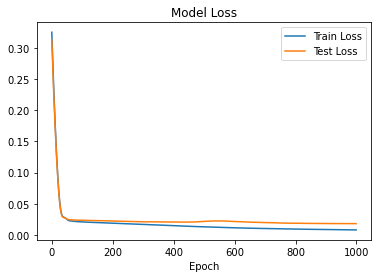

In [15]:
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.legend()

plt.savefig('figures/training_loss.png')
plt.show()

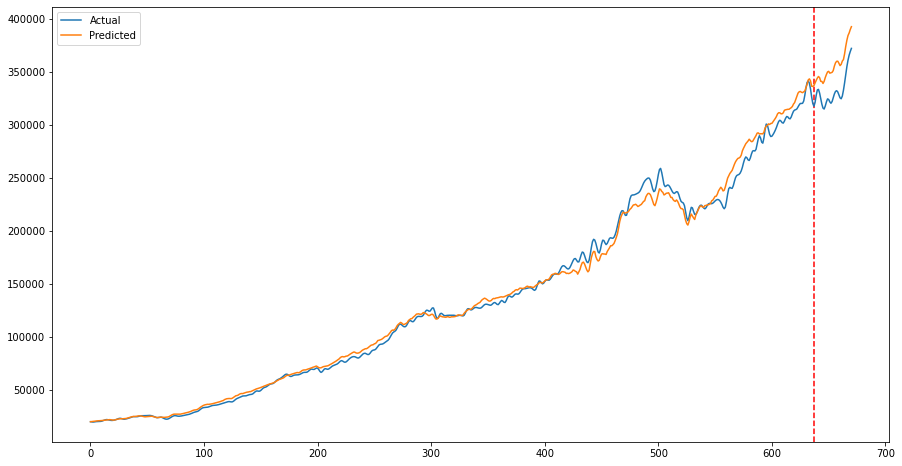

In [16]:
# Plot predictions vs actual

def inverse_pct_change(series, y_0):
    np_series = np.array(series)  # Use np array for built in cumsum
    np_series[0] = np.log(y_0)
    cumulative_sum = np_series.cumsum()
    
    return np.exp(cumulative_sum)


# Get data into the right format
X_tensors = torch.Tensor(X_seq)
y_tensors = torch.Tensor(y_seq)

X_tensors = torch.reshape(X_tensors, (X_tensors.shape[0], IN_SEQ_LENGTH, X_tensors.shape[2]))

# Get predictions and actual
predictions_scaled = lstm1(X_tensors).data.numpy()  # Convert to numpy for plotting
actual_scaled = y_tensors.data.numpy()

# Reverse scaling transformations
predictions_seq = minmax_scaler.inverse_transform(predictions_scaled)  # y values used minmax scaler earlier
actual_seq = minmax_scaler.inverse_transform(actual_scaled)

# Reverse sequence transformations
predictions = [predictions_seq[i][0] for i in range(len(predictions_seq))]
actual = [actual_seq[i][0] for i in range(len(actual_seq))]

# Reverse log difference transformations
first_idx = IN_SEQ_LENGTH

first_target = df_raw['MSPUS'].iat[first_idx]  # First MSPUS value before log differencing
predictions_final = inverse_pct_change(predictions, first_target)
actual_final = inverse_pct_change(actual, first_target)

# Plot
plt.figure(figsize=(15, 8))


train_test_cutoff = round((1-TEST_SIZE) * X_tensors.shape[0])  # Index where test data starts
plt.axvline(x=train_test_cutoff, c='red', linestyle='--')

plt.plot(actual_final, label='Actual')
plt.plot(predictions_final, label='Predicted')
plt.legend()
plt.savefig('figures/actual_vs_predicted.png')

plt.show()

In [17]:
# Predict future based only on last in sequence length

# Get last MSPUS value before start of predictions
def get_test_actual(test_size, df):
    test_start_idx = -test_size
    df_idx = df.reset_index()
    test_actual = df_idx.iloc[test_start_idx:]
    test_actual = np.array(test_actual['MSPUS'])
    
    return test_actual
    
test_actual = get_test_actual(OUT_SEQ_LENGTH, df_raw)
FIRST_TARGET = test_actual[0]

def get_predictions(model, X_test_tensors, first_target):
    # Predictions
    test_predictions = model(X_test_tensors[-1].unsqueeze(0)).detach().numpy()  # Get the last sample
    test_predictions = minmax_scaler.inverse_transform(test_predictions)  # Reverse scaling transform
    test_predictions = test_predictions[0].tolist()
    test_predictions = inverse_pct_change(test_predictions, first_target)
    
    return test_predictions



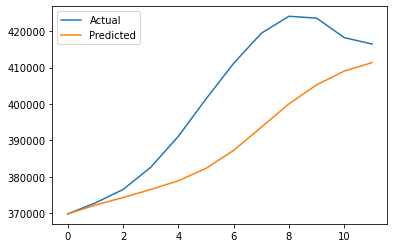

In [18]:


test_predictions = get_predictions(lstm1, X_val_tensors, FIRST_TARGET)

# Actual

#test_actual = np.array(test_actual['MSPUS'])

#test_actual = y_val_tensors[-1].detach().numpy()  # Last actual y
#test_actual = minmax_scaler.inverse_transform(test_actual.reshape(1, -1))
#test_actual = test_actual[0].tolist()
#test_actual = inverse_pct_change(test_actual, FIRST_TARGET)

plt.plot(test_actual, label="Actual")
plt.plot(test_predictions, label="Predicted")
plt.legend()
plt.savefig('figures/actual_vs_predicted_end.png')

plt.show()

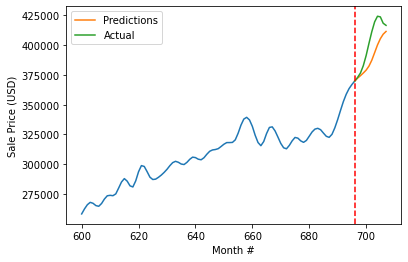

In [19]:
# Full scale actual vs predicted plot

def plot_actual_vs_pred(test_predictions, test_actual, y, plot_savename):
    N = len(y)
    CUTOFF = 600  # 200 for quarterly data
    
    actual_slice_end = N - OUT_SEQ_LENGTH + 1
    
    actual_slice = [i for i in range(CUTOFF, actual_slice_end)]
    pred_slice = [i for i in range(N - OUT_SEQ_LENGTH, N)]
    plt.plot(actual_slice, y[CUTOFF:actual_slice_end])
    plt.plot(pred_slice, test_predictions, label='Predictions')
    plt.plot(pred_slice, test_actual, label='Actual')
    plt.axvline(x=len(y)-OUT_SEQ_LENGTH, c='red', linestyle='--')


    plt.legend()
    plt.xlabel('Month #')
    plt.ylabel('Sale Price (USD)')
    #plt.savefig(plot_savename, bbox_inches='tight')
    plt.show()
    
plot_name = 'figures/scale_actual_vs_pred.png'
plot_actual_vs_pred(test_predictions, test_actual, df_raw['MSPUS'], plot_name)

In [20]:
# Save test predictions
print(test_predictions)
np.savetxt('best_test_preds.csv', test_predictions, delimiter=',')

[369800.         372231.36203945 374289.02166474 376507.42636058
 378916.19489553 382325.51627972 387280.38501724 393637.98083803
 400063.58713602 405286.28643295 409080.61914632 411381.7766447 ]


In [21]:
# Compute standard error
N = len(test_actual)
SS_err = ((test_predictions - test_actual)**2).sum()
std_err = np.sqrt( SS_err / (N-2))

# Compute residual variance
# aka r^2 = 1 - R^2
y_vals = df_raw['MSPUS'].copy()
SS_tot = ((y_vals - y_vals.mean())**2).sum()
res_var = SS_err / SS_tot

# Compute r squared
r2 = 1 - res_var

# Compute RMSE
mse = sklearn.metrics.mean_squared_error(test_predictions, test_actual)
rmse = np.sqrt(mse)

print('Residual Variance:', res_var)
print('R^2:', r2)
print('Standard Error:', std_err)
#print('MSE:', mse)
print('RMSE:', rmse)

Residual Variance: 0.0003819241462328878
R^2: 0.9996180758537672
Standard Error: 16789.22971288976
RMSE: 15326.399728142842


### Run Multiple Models

In [22]:
all_predictions = []
for i in range(50):
    torch.manual_seed(i)
    
    model = LSTM(N_CLASSES,
            INPUT_SIZE,
            HIDDEN_SIZE,
            N_LAYERS
           )
    print('------------TRAINING MODEL {}--------------'.format(i+1))
    train_loss, test_loss = train_model(model)
    
    all_predictions.append(get_predictions(model, X_val_tensors, FIRST_TARGET))


------------TRAINING MODEL 1--------------
Epoch 0: Train loss: 0.35297731 Test loss: 0.338676601648331
Epoch 100: Train loss: 0.02074193 Test loss: 0.023208528757095
Epoch 200: Train loss: 0.01883603 Test loss: 0.022077238187194
Epoch 300: Train loss: 0.01733035 Test loss: 0.022538851946592
Epoch 400: Train loss: 0.01584534 Test loss: 0.022915538400412
Epoch 500: Train loss: 0.01446301 Test loss: 0.023478755727410
Epoch 600: Train loss: 0.01308739 Test loss: 0.025097811594605
Epoch 700: Train loss: 0.01191259 Test loss: 0.026407288387418
Epoch 800: Train loss: 0.01094136 Test loss: 0.025769988074899
Epoch 900: Train loss: 0.01012049 Test loss: 0.024979656562209
------------TRAINING MODEL 2--------------
Epoch 0: Train loss: 0.35258499 Test loss: 0.340694576501846
Epoch 100: Train loss: 0.02107623 Test loss: 0.024961654096842
Epoch 200: Train loss: 0.01931069 Test loss: 0.023528374731541
Epoch 300: Train loss: 0.01788126 Test loss: 0.024145796895027
Epoch 400: Train loss: 0.01608794 Te

Epoch 200: Train loss: 0.01983743 Test loss: 0.022739225998521
Epoch 300: Train loss: 0.01847962 Test loss: 0.022058561444283
Epoch 400: Train loss: 0.01663598 Test loss: 0.022116113454103
Epoch 500: Train loss: 0.01478494 Test loss: 0.022310895845294
Epoch 600: Train loss: 0.01317407 Test loss: 0.022906489670277
Epoch 700: Train loss: 0.01185723 Test loss: 0.023879608139396
Epoch 800: Train loss: 0.01086910 Test loss: 0.023762030526996
Epoch 900: Train loss: 0.01009273 Test loss: 0.023739233613014
------------TRAINING MODEL 14--------------
Epoch 0: Train loss: 0.34013340 Test loss: 0.324332594871521
Epoch 100: Train loss: 0.02109770 Test loss: 0.023900970816612
Epoch 200: Train loss: 0.01951483 Test loss: 0.022894902154803
Epoch 300: Train loss: 0.01789028 Test loss: 0.021775608882308
Epoch 400: Train loss: 0.01568043 Test loss: 0.021367723122239
Epoch 500: Train loss: 0.01386889 Test loss: 0.020756214857101
Epoch 600: Train loss: 0.01213992 Test loss: 0.019940963014960
Epoch 700: Tr

Epoch 500: Train loss: 0.01275804 Test loss: 0.021086191758513
Epoch 600: Train loss: 0.01128310 Test loss: 0.020702200010419
Epoch 700: Train loss: 0.01012680 Test loss: 0.020659059286118
Epoch 800: Train loss: 0.00924147 Test loss: 0.020145177841187
Epoch 900: Train loss: 0.00851229 Test loss: 0.019753759726882
------------TRAINING MODEL 26--------------
Epoch 0: Train loss: 0.35658172 Test loss: 0.342439502477646
Epoch 100: Train loss: 0.02101640 Test loss: 0.023770663887262
Epoch 200: Train loss: 0.01942093 Test loss: 0.023291202262044
Epoch 300: Train loss: 0.01804994 Test loss: 0.023201325908303
Epoch 400: Train loss: 0.01617854 Test loss: 0.023478470742702
Epoch 500: Train loss: 0.01461578 Test loss: 0.023297604173422
Epoch 600: Train loss: 0.01288711 Test loss: 0.022053807973862
Epoch 700: Train loss: 0.01147546 Test loss: 0.020671138539910
Epoch 800: Train loss: 0.01040961 Test loss: 0.020594824105501
Epoch 900: Train loss: 0.00953942 Test loss: 0.020549487322569
------------T

Epoch 800: Train loss: 0.01010879 Test loss: 0.025225577875972
Epoch 900: Train loss: 0.00934865 Test loss: 0.025873908773065
------------TRAINING MODEL 38--------------
Epoch 0: Train loss: 0.33734217 Test loss: 0.323903143405914
Epoch 100: Train loss: 0.02049165 Test loss: 0.023158039897680
Epoch 200: Train loss: 0.01891591 Test loss: 0.021982826292515
Epoch 300: Train loss: 0.01699458 Test loss: 0.022258305922151
Epoch 400: Train loss: 0.01521580 Test loss: 0.023591542616487
Epoch 500: Train loss: 0.01319806 Test loss: 0.023815084248781
Epoch 600: Train loss: 0.01150965 Test loss: 0.022597417235374
Epoch 700: Train loss: 0.01026091 Test loss: 0.021116929128766
Epoch 800: Train loss: 0.00916138 Test loss: 0.021147968247533
Epoch 900: Train loss: 0.00824031 Test loss: 0.021428463980556
------------TRAINING MODEL 39--------------
Epoch 0: Train loss: 0.33022156 Test loss: 0.314854413270950
Epoch 100: Train loss: 0.02146163 Test loss: 0.023437794297934
Epoch 200: Train loss: 0.01994443 

Epoch 100: Train loss: 0.02091661 Test loss: 0.023979866877198
Epoch 200: Train loss: 0.01901090 Test loss: 0.022913912311196
Epoch 300: Train loss: 0.01686361 Test loss: 0.021743007004261
Epoch 400: Train loss: 0.01471301 Test loss: 0.021101592108607
Epoch 500: Train loss: 0.01311351 Test loss: 0.020896997302771
Epoch 600: Train loss: 0.01180264 Test loss: 0.021157860755920
Epoch 700: Train loss: 0.01073461 Test loss: 0.022653004154563
Epoch 800: Train loss: 0.00972558 Test loss: 0.024758880957961
Epoch 900: Train loss: 0.00896167 Test loss: 0.026229372248054


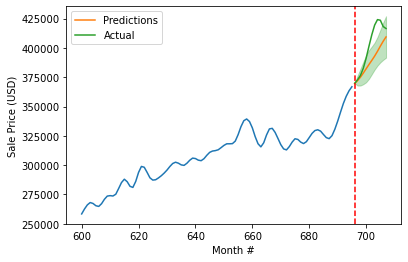

In [23]:
# Plot multi model average predictions with std devs

def plot_actual_vs_pred_multimodel(test_predictions, test_actual, actual_final, plot_savename):
    N = len(actual_final)
    
    test_predictions = np.array(test_predictions)
    avg_pred = test_predictions.mean(axis=0)
    std_pred = test_predictions.std(axis=0)

    actual_slice = [i for i in range(600, N - OUT_SEQ_LENGTH)]
    pred_slice = [i for i in range(N - OUT_SEQ_LENGTH, N)]
    plt.plot(actual_slice, actual_final[600:N - OUT_SEQ_LENGTH])
    plt.plot(pred_slice, avg_pred, label='Predictions')
    z = 1.96
    plt.fill_between(pred_slice,  # Fill prediction interval
                     avg_pred + z*std_pred, 
                     avg_pred - z*std_pred, 
                     alpha=0.3, 
                     color='C2'
                    )
    plt.plot(pred_slice, test_actual, label='Actual')
    plt.axvline(x=len(actual_final)-OUT_SEQ_LENGTH, c='red', linestyle='--')


    plt.legend()
    plt.xlabel('Month #')
    plt.ylabel('Sale Price (USD)')
    plt.savefig(plot_savename, bbox_inches='tight')
    plt.show()
    

plot_name = 'figures/actual_vs_pred_multimodel.png'
plot_actual_vs_pred_multimodel(all_predictions, test_actual, df_raw['MSPUS'], plot_name)

### Sanity Check Functions

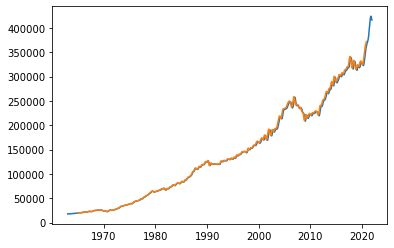

DatetimeIndex(['1963-01-01', '1963-02-01', '1963-03-01', '1963-04-01',
               '1963-05-01', '1963-06-01', '1963-07-01', '1963-08-01',
               '1963-09-01', '1963-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='DATE', length=708, freq=None)
DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01'],
              dtype='datetime64[ns]', name='DATE', length=671, freq=None)


In [24]:
# Reverse transform sanity check
actual_df = pd.DataFrame(actual_final, index=df_raw['MSPUS'].index[first_idx:-13])

plt.plot(df_raw['MSPUS'], label='Raw')
plt.plot(actual_df, label='Transformed')

plt.show()
print(df_raw['MSPUS'].index)
print(actual_df.index)

In [25]:
# Test inverse_pct_change

np.random.seed(0)

s = pd.Series(np.random.randint(100000, 300000, size=10))

print(s.values)

t = np.log(s).diff()
t.iat[0] = np.log(s.iat[0])
res = np.exp(t.cumsum())

print(res.values)

test = inverse_pct_change(t, s.iat[0])
print(test)

[299340 143567 273685 217952 276963 252315 195939 197639 141993 222579]
[299340. 143567. 273685. 217952. 276963. 252315. 195939. 197639. 141993.
 222579.]
[299340. 143567. 273685. 217952. 276963. 252315. 195939. 197639. 141993.
 222579.]
